### **Importing needed libraries**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from IPython.display import display, Markdown
from math import fabs
import json

### **Load data**

In [2]:
PATH_TO_DATA = "radio_train"
PATH_TO_MODEL = "models"
PATH_TO_HISTORIES = "learning_histories"

In [3]:
input_df = pd.read_csv(os.path.join(PATH_TO_DATA, os.listdir(PATH_TO_DATA)[0]), names=[f"o{i}" for i in range(1, 17)])
target_df = pd.read_csv(os.path.join(PATH_TO_DATA, os.listdir(PATH_TO_DATA)[1]), names=["x_cord", "y_cord", "error"])

In [4]:
input_df.head(5)

,o1,o2,o3,o4,o5,o6,o7,o8,o9,o10,o11,o12,o13,o14,o15,o16
0,0.325311,0.355525,0.397343,0.284162,0.408696,0.853002,0.481582,0.365663,0.624396,0.630032,0.277494,0.135749,0.222464,0.361413,0.302174,0.125000
1,0.322621,0.348229,0.426276,0.285427,0.404809,0.853958,0.480490,0.371696,0.617918,0.633816,0.280904,0.128623,0.246894,0.367754,0.316667,0.098551
2,0.323370,0.346121,0.439242,0.280596,0.405495,0.853002,0.486542,0.363872,0.619163,0.627599,0.288647,0.135393,0.229469,0.358696,0.306612,0.102355
3,0.324827,0.342754,0.432174,0.276641,0.405217,0.853002,0.482163,0.361514,0.614332,0.630120,0.285507,0.131550,0.230490,0.365942,0.317391,0.111111
4,0.325362,0.347497,0.439538,0.283126,0.416476,0.852484,0.486473,0.361660,0.616667,0.628909,0.288768,0.127415,0.240777,0.362319,0.304865,0.112319


In [5]:
input_df.max()

o1     0.883632
o2     0.942754
o3     0.965294
o4     0.818414
o5     0.968917
o6     0.865106
o7     0.890359
o8     0.934783
o9     0.955448
o10    0.818841
o11    0.810716
o12    0.832497
o13    0.901895
o14    0.896262
o15    0.942935
o16    0.855073
dtype: float64

In [6]:
input_df.min()

o1     0.198240
o2     0.197971
o3     0.169011
o4     0.127847
o5     0.107661
o6     0.000000
o7     0.121830
o8     0.233243
o9     0.309179
o10    0.067194
o11    0.075052
o12    0.000000
o13    0.194099
o14    0.161685
o15    0.146042
o16    0.000000
dtype: float64

### **Changing data types in order to reduce memory usage**

In [7]:
input_df = input_df.astype({col: np.float32 for col in input_df.columns})

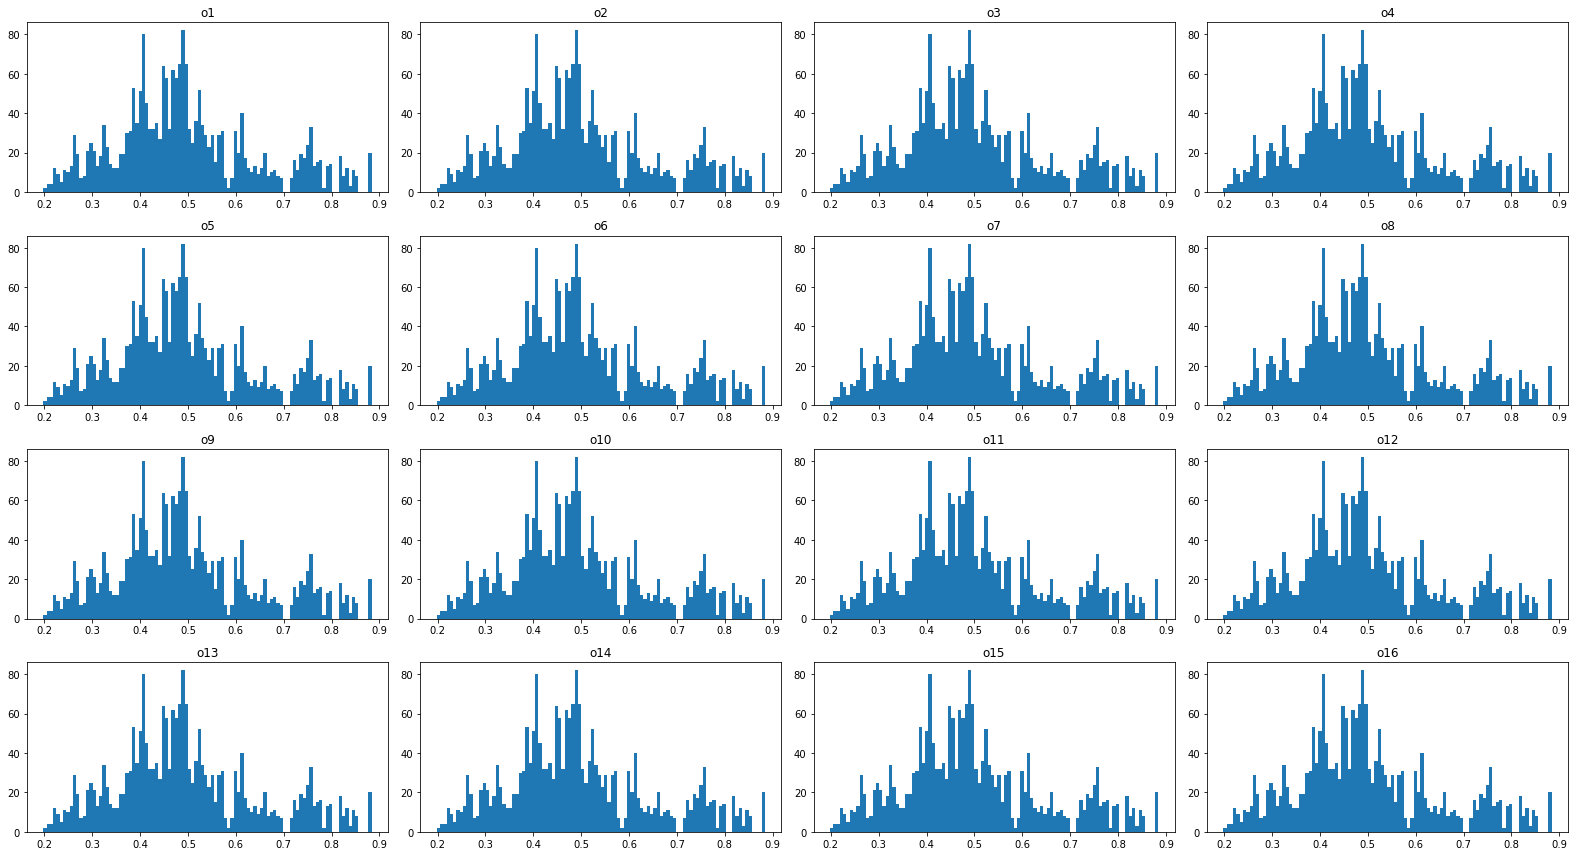

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(22, 12))
for i, column in enumerate(input_df.columns):
    ax[i // 4, i % 4].hist(input_df["o1"], bins=100)
    ax[i // 4, i % 4].set_title(column)

plt.tight_layout()
plt.savefig("images/output4.png")

In [9]:
input_df.dtypes

o1     float32
o2     float32
o3     float32
o4     float32
o5     float32
o6     float32
o7     float32
o8     float32
o9     float32
o10    float32
o11    float32
o12    float32
o13    float32
o14    float32
o15    float32
o16    float32
dtype: object

In [10]:
target_df['error'].value_counts()

0.0    2160
Name: error, dtype: int64

### **Dropping column which does not provide any information**

In [11]:
target_df = target_df.drop(columns=['error'], axis=1)

### **Checking missing values**

In [12]:
input_df.isna().sum()

o1     0
o2     0
o3     0
o4     0
o5     0
o6     0
o7     0
o8     0
o9     0
o10    0
o11    0
o12    0
o13    0
o14    0
o15    0
o16    0
dtype: int64

In [13]:
target_df.isna().sum()

x_cord    0
y_cord    0
dtype: int64

### **Normalization**

In [14]:
def normalize(x_array: np.array) -> np.array:

    max_value, min_value = max(x_array), min(x_array)
    return (x_array - min_value) / (max_value - min_value)


In [15]:
input_df = input_df.apply(normalize, axis=1)

### **Splitting into train, validation and test sets**

In [16]:
x_train_b, x_test, y_train_b, y_test = train_test_split(input_df, target_df, train_size=0.8, random_state=42)

In [17]:
x_train_b.shape, x_test.shape, y_train_b.shape, y_test.shape

((1728, 16), (432, 16), (1728, 2), (432, 2))

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train_b, y_train_b, train_size=0.8, random_state=42)

In [20]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1382, 16), (346, 16), (1382, 2), (346, 2))

### **Chosing best hyperparameters by means of keras Hyperband**

In [50]:
def build_model(hp):
    
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=8, max_value=64, step=8)
    lr = hp.Choice("learning_rate", [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-4, 1e-2, 5e-2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="elu"))
        model.add(tf.keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.Dense(2))

    model.compile(loss="mean_squared_error", 
                  optimizer=optimizer,
                  metrics=["mean_absolute_error"])
                  
    return model

In [51]:
path_to_csv_results = os.path.join("results", "train_history.csv")

In [19]:
callbacks = [EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)]

In [88]:
hyperband_tuner = kt.Hyperband(build_model, 
                               objective="val_loss", 
                               seed=42,
                               max_epochs=120, 
                               factor=3,
                               hyperband_iterations=2,
                               overwrite=True, 
                               directory="hyperband", 
                               project_name="hyperband_2")

In [89]:
hyperband_tuner.search(x_train, 
                       y_train,
                       epochs=120,
                       validation_data=(x_val, y_val),
                       callbacks=callbacks)

Trial 508 Complete [00h 00m 09s]
val_loss: 0.02319932170212269

Best val_loss So Far: 4.8419100494356826e-05
Total elapsed time: 00h 11m 35s
INFO:tensorflow:Oracle triggered exit


In [20]:
with open(os.path.join("best_params_config", "params_config.json"), "r") as f:
    params_config = json.load(f)
    
params_config

{'no_dropout_120_epochs': {'n_hidden': 4,
  'n_neurons': 64,
  'learning_rate': 0.01,
  'dropout': False},
 'dropout_120_epochs': {'n_hidden': 4,
  'n_neurons': 40,
  'learning_rate': 0.01,
  'dropout': True}}

In [21]:
def build_model_from_params(n_neurons: int, 
                            n_hidden: int, 
                            learning_rate: float, 
                            dropout=False) -> tf.keras.Sequential:

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    for _ in range(n_hidden):
        
        model.add(tf.keras.layers.Dense(n_neurons, activation="elu"))
        if dropout:
            model.add(tf.keras.layers.Dropout(0.15))

    model.add(tf.keras.layers.Dense(2))

    model.compile(loss="mean_squared_error", 
                  optimizer=optimizer,
                  metrics=["mean_absolute_error"])
    
    return model 

In [23]:
chosen_model = "no_dropout_120_epochs"
model_config = params_config[chosen_model]

In [24]:
best_model_from_params = build_model_from_params(model_config['n_neurons'],
                                                 model_config['n_hidden'],
                                                 model_config['learning_rate'],
                                                 model_config['dropout'])

In [25]:
learning_history = best_model_from_params.fit(x_train,
                                              y_train,
                                              epochs=120,
                                              validation_data=(x_val, y_val),
                                              callbacks=callbacks)

Epoch 1/120
44/44 [==============================] - 1s 5ms/step - loss: 0.0455 - mean_absolute_error: 0.1363 - val_loss: 0.0012 - val_mean_absolute_error: 0.0274 - lr: 0.0100
Epoch 2/120
44/44 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0463 - val_loss: 8.1980e-04 - val_mean_absolute_error: 0.0231 - lr: 0.0100
Epoch 3/120
44/44 [==============================] - 0s 1ms/step - loss: 0.0021 - mean_absolute_error: 0.0365 - val_loss: 7.6597e-04 - val_mean_absolute_error: 0.0220 - lr: 0.0100
Epoch 4/120
44/44 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0340 - val_loss: 7.4992e-04 - val_mean_absolute_error: 0.0215 - lr: 0.0100
Epoch 5/120
44/44 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0319 - val_loss: 7.3822e-04 - val_mean_absolute_error: 0.0215 - lr: 0.0100
Epoch 6/120
44/44 [==============================] - 0s 2ms/step - loss: 0.0015 - mean_absolute_error: 0

In [188]:
best_model_from_params.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 16)                0         
                                                                 
 dense_91 (Dense)            (None, 64)                1088      
                                                                 
 dense_92 (Dense)            (None, 64)                4160      
                                                                 
 dense_93 (Dense)            (None, 64)                4160      
                                                                 
 dense_94 (Dense)            (None, 64)                4160      
                                                                 
 dense_95 (Dense)            (None, 2)                 130       
                                                                 
Total params: 13,698
Trainable params: 13,698
Non-tra

In [187]:
learning_df = pd.DataFrame(learning_history.history)
learning_df.to_parquet(os.path.join(PATH_TO_HISTORIES, "no_dropout_120_epochs_history.parquet.gzip"))

In [26]:
initial_epoch = 0

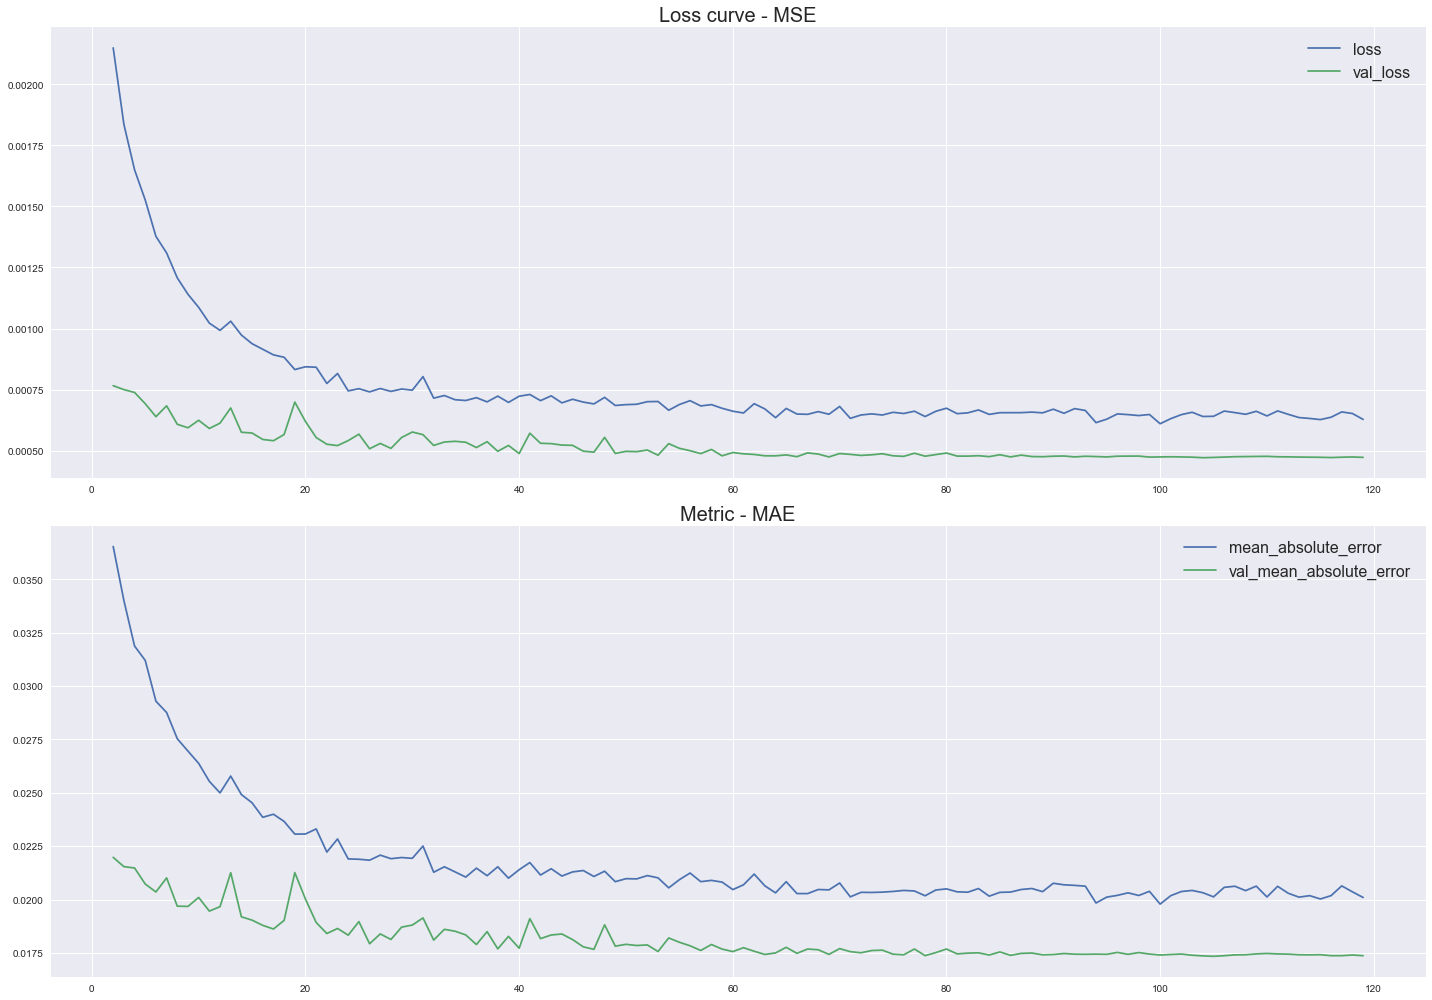

In [27]:
plt.style.use('seaborn')
fig, axes = plt.subplots(2, 1, figsize=(20, 14))
titles = ['Loss curve - MSE', 'Metric - MAE']

for index, (metric, values) in enumerate(learning_history.history.items()):

    if metric == 'lr':
        continue

    axes[index % 2].plot([i for i in range(initial_epoch + 2, initial_epoch + len(values))], values[2:], label=metric)
    axes[index % 2].legend(fontsize=16)
    axes[index % 2].set_title(titles[index % 2], fontsize=20)
    # axes[0 if index < 2 else 1].set_title(metric)
    # axes[0 if index < 2 else 1, index % 2].plot(values)

plt.tight_layout()
plt.show()

In [25]:
model_name = "best_model_120_epochs.ckpt"
best_model = tf.keras.models.load_model(os.path.join(PATH_TO_MODEL, model_name))

### **Predictions**

In [26]:
x_train_preds = best_model.predict(x_train)
x_val_preds = best_model.predict(x_val)
x_test_preds = best_model.predict(x_test)

### **Metrics for train set**

In [27]:
display(Markdown(f"#### **MAE: {mean_absolute_error(y_train, x_train_preds):.2e}<br>MSE: {mean_squared_error(y_train, x_train_preds):.2e}**"))

#### **MAE: 3.00e-03<br>MSE: 1.54e-05**

### **Metrics for validation set**

In [28]:
display(Markdown(f"#### **MAE: {mean_absolute_error(y_val, x_val_preds):.2e}<br>MSE: {mean_squared_error(y_val, x_val_preds):.2e}**"))

#### **MAE: 3.11e-03<br>MSE: 1.59e-05**

### **Metrics for test set**

In [29]:
display(Markdown(f"#### **MAE: {mean_absolute_error(y_test, x_test_preds):.2e}<br>MSE: {mean_squared_error(y_test, x_test_preds):.2e}**"))

#### **MAE: 3.34e-03<br>MSE: 1.95e-05**

### **5-fold cross validation**

In [30]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [31]:
x_train_b, y_train_b = np.array(x_train_b), np.array(y_train_b)

In [32]:
callbacks_kfold = [EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True),
             # CSVLogger(path_to_csv_results, append=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)]

In [33]:
train_MAE_ag, train_MSE_ag, test_MAE_ag, test_MSE_ag = [], [], [], []

for fold_index, (train_index, test_index) in enumerate(kfold.split(x_train_b), start=1):

    x_train_folds, x_test_fold = x_train_b[train_index], x_train_b[test_index]
    y_train_folds, y_test_fold = y_train_b[train_index], y_train_b[test_index]

    model = build_model_from_params(n_neurons=model_config['n_neurons'],
                                    n_hidden=model_config['n_hidden'],
                                    learning_rate=model_config['learning_rate'],
                                    dropout=model_config['dropout'])

    learning_history = model.fit(x_train_folds,
                                 y_train_folds,
                                 epochs=120,
                                 validation_split=0.2,
                                 # validation_data=(x_val, y_val),
                                 callbacks=callbacks_kfold,
                                 verbose=0)


    x_train_folds_preds = model.predict(x_train_folds)
    x_test_fold_preds = model.predict(x_test_fold)

    train_MAE, train_MSE = mean_absolute_error(y_train_folds, x_train_folds_preds), \
                           mean_squared_error(y_train_folds, x_train_folds_preds)

    test_MAE, test_MSE = mean_absolute_error(y_test_fold, x_test_fold_preds), \
                         mean_squared_error(y_test_fold, x_test_fold_preds)

    result_for_fold = f"### **{fold_index}. fold <br> \
                        Mean absolute error for train folds: {train_MAE:.2e} <br> \
                        Mean absolute error for test fold: {test_MAE:.2e} <br> \
                        Mean squared error for train folds: {train_MSE:.2e} <br> \
                        Mean squared error for test fold: {test_MSE:.2e}<br>**"

    display(Markdown(result_for_fold))

    train_MAE_ag.append(train_MAE)
    train_MSE_ag.append(train_MSE)
    test_MAE_ag.append(test_MAE)
    test_MSE_ag.append(test_MSE)

### **1. fold <br>                         Mean absolute error for train folds: 9.78e-03 <br>                         Mean absolute error for test fold: 1.02e-02 <br>                         Mean squared error for train folds: 1.70e-04 <br>                         Mean squared error for test fold: 1.84e-04<br>**

### **2. fold <br>                         Mean absolute error for train folds: 8.92e-03 <br>                         Mean absolute error for test fold: 9.47e-03 <br>                         Mean squared error for train folds: 1.38e-04 <br>                         Mean squared error for test fold: 1.54e-04<br>**

### **3. fold <br>                         Mean absolute error for train folds: 8.97e-03 <br>                         Mean absolute error for test fold: 9.34e-03 <br>                         Mean squared error for train folds: 1.44e-04 <br>                         Mean squared error for test fold: 1.55e-04<br>**

### **4. fold <br>                         Mean absolute error for train folds: 6.91e-03 <br>                         Mean absolute error for test fold: 7.42e-03 <br>                         Mean squared error for train folds: 8.32e-05 <br>                         Mean squared error for test fold: 9.99e-05<br>**

### **5. fold <br>                         Mean absolute error for train folds: 8.39e-03 <br>                         Mean absolute error for test fold: 9.01e-03 <br>                         Mean squared error for train folds: 1.23e-04 <br>                         Mean squared error for test fold: 1.45e-04<br>**

In [34]:
average_results = f"### **Average MAE for train folds: {sum(train_MAE_ag) / len(train_MAE_ag):.3e} <br> \
                        Average MAE for test folds: {sum(test_MAE_ag) / len(test_MAE_ag):.3e} <br> \
                        Average MSE for train folds: {sum(train_MSE_ag) / len(train_MSE_ag):.3e} <br> \
                        Average MSE for test folds: {sum(test_MSE_ag) / len(test_MSE_ag):.3e}**"

display(Markdown(average_results))

### **Average MAE for train folds: 8.592e-03 <br>                         Average MAE for test folds: 9.087e-03 <br>                         Average MSE for train folds: 1.315e-04 <br>                         Average MSE for test folds: 1.476e-04**

### **Sample results**

In [35]:
real_10_first_rows = y_test.iloc[:10, ].reset_index(drop=True)
preds_10_first_rows = pd.DataFrame(best_model.predict(x_test[:10]), columns=[f"{col}_pred" for col in y_test.columns])

In [36]:
con_results = pd.concat([real_10_first_rows, preds_10_first_rows], axis=1)
con_results["x_diff"] = abs(con_results["x_cord"] - con_results["x_cord_pred"])
con_results["y_diff"] = abs(con_results["y_cord"] - con_results["y_cord_pred"])
con_results = con_results.sort_index(axis=1)
con_results

,x_cord,x_cord_pred,x_diff,y_cord,y_cord_pred,y_diff
0,0.059429,0.059779,0.000351,-0.037740,-0.041111,0.003371
1,-0.072596,-0.070814,0.001782,-0.042491,-0.042100,0.000391
2,0.059429,0.060559,0.001131,-0.037740,-0.042826,0.005086
3,-0.061692,-0.064895,0.003202,0.092123,0.098376,0.006253
4,-0.125053,-0.129174,0.004121,-0.010289,-0.009446,0.000843
5,0.028191,0.026310,0.001881,-0.002371,-0.003460,0.001090
6,0.001668,0.000712,0.000956,0.084732,0.092168,0.007436
7,0.014929,0.017427,0.002497,0.055170,0.051486,0.003685
8,-0.108844,-0.102121,0.006724,0.092651,0.093759,0.001109
9,0.044988,0.051497,0.006508,-0.004482,-0.004715,0.000232


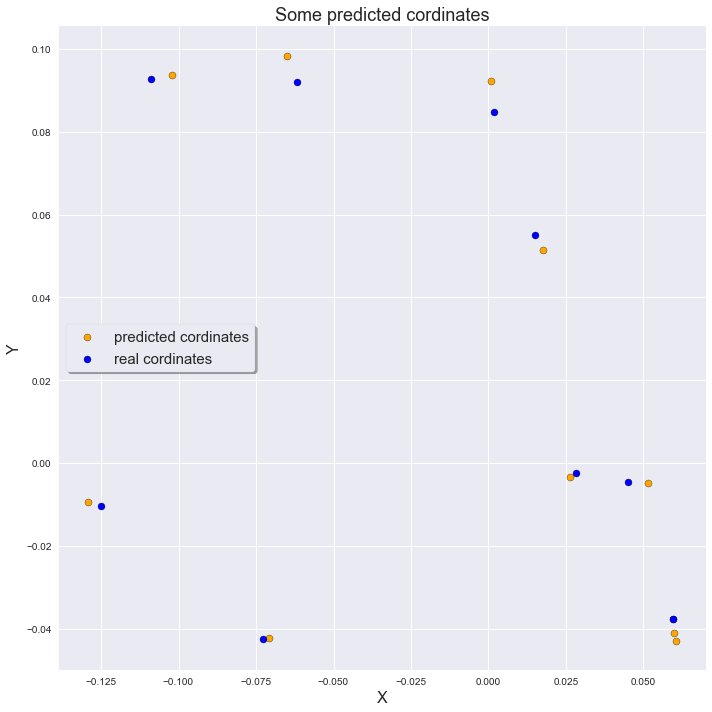

In [37]:
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(con_results["x_cord_pred"], con_results["y_cord_pred"], color="orange", label="predicted cordinates", edgecolors="black")
ax.scatter(con_results["x_cord"], con_results["y_cord"], color="blue", label="real cordinates", edgecolors="black")
ax.legend(fontsize=15, shadow=True, frameon=True, loc=6)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.set_title("Some predicted cordinates", fontsize=18)
plt.tight_layout()
plt.show()